<a href="https://colab.research.google.com/github/gggrune-labs/gggrune-labs/blob/main/ER_Visit_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Emercancy room utilization using synthetic healthcare data

# Project Overview

This notebook demonstrates a full data scinece pipeline built around a synthetic healthcare dataset.

**Goal:** Predict the number of emergency room visit in the past year sing patient demogrpahich and clinical features.

I:
- Generated synthetic medical data for 100,000 patitents
- Cleaned and explored the data
- Wrote a script for a LLM to predict ER visits
- Evaluated model preformance and interpreted key features

The dataset was create using Python's 'fake', 'numpy', and 'random' libraries, and is designed to mimic realistic healthcaer attibutes while preserving privacy.

In [3]:
pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.9 MB/s eta 0:00:00


Section 2: Load and Inspect and clean Data

In [4]:
import pandas as pd
import random
import numpy as np
from faker import Faker

# Initialize Faker and random seeds for  reproduction
fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)

# Settings
num_records = 100000
ethnicities = ['Hispanic', 'Latino', 'Black', 'Caucasian', 'Native American', 'Asian', 'Pacific Islander', 'Multiracial', 'Other']
genders = ['Male', 'Female', 'Transgender-Male', 'Transgender-Female', 'Non-Binary']
smoking_statuses = ['Never smoked', 'Former Smoker', 'Current smoker']
chronic_conditions_pool = ['Hypertension', 'Diabetes', 'Asthma', 'COPD', 'Heart Disease', 'Obesity', 'Depression', 'Arthritis', 'Lung Cancer']
medications_pool = ['Metformin', 'Lisinopril', 'Atorvastatin', 'Albuterol', 'Levothyroxine', 'Amlodipine', 'Omeprazole', 'Simvastatin']
diagnosis_codes = ['E11.9', 'I10', 'J45.909', 'J44.9', 'I25.10', 'E66.9', 'F32.9', 'M19.9', 'C34.0']

# Ensure even ethnicity distribution
ethnicity_list = ethnicities * (num_records // len(ethnicities))
ethnicity_list += random.sample(ethnicities, num_records % len(ethnicities))
random.shuffle(ethnicity_list)

# Create synthetic data
data = []
for i in range(num_records):
    patient_id = i + 1
    first_name = fake.first_name()
    gender = random.choice(genders)
    age = random.randint(15, 99)
    ethnicity = ethnicity_list[i]
    insured = random.choice(['Yes', 'No'])
    diagnosis_code = random.choice(diagnosis_codes)
    chronic_conditions = random.sample(chronic_conditions_pool, random.randint(1, 3))
    num_er_visits_last_year = np.random.poisson(1)
    medications = random.sample(medications_pool, random.randint(1, 3))
    smoking_status = random.choice(smoking_statuses)
    bmi = round(random.uniform(16.0, 45.0), 1)
    systolic_bp = random.randint(90, 180)
    last_visit_date = fake.date_between(start_date='-2y', end_date='today')

    data.append([
        patient_id, first_name, gender, age, ethnicity, insured,
        diagnosis_code, chronic_conditions, num_er_visits_last_year,
        medications, smoking_status, bmi, systolic_bp, last_visit_date
    ])

# Define column names
columns = [
    'patient_id', 'first_name', 'gender', 'age', 'ethnicity', 'insured',
    'diagnosis_code', 'chronic_conditions', 'num_er_visits_last_year',
    'medications', 'smoking_status', 'bmi', 'systolic_bp', 'last_visit_date'
]

# Create DataFrame and export
df = pd.DataFrame(data, columns=columns)
df.to_csv("medical_clinical_data.csv", index=False)

print("✅ CSV file 'medical_clinical_data.csv' created successfully.")

✅ CSV file 'medical_clinical_data.csv' created successfully.


In [8]:
import pandas as pd

# Load the original data
df = pd.read_csv("medical_clinical_data.csv")

# Flatten list-like strings (Some data was saved as strings with brackets)
def clean_list_column(col):
    return col.str.replace(r"[\[\]']", "", regex=True)

df['chronic_conditions'] = clean_list_column(df['chronic_conditions'])
df['medications'] = clean_list_column(df['medications'])

# Standardize categorical columns (strip spaces, title cases)
cat_col = ['first_name', 'gender', 'ethnicity', 'insured', 'smoking_status']
for col in cat_col:
    df[col] = df[col].str.strip().str.title()

# Convert data to datetime format
df['last_visit_date'] = pd.to_datetime(df['last_visit_date'])

# Ensure numeric columns are correctly typed
numeric_cols = ['age', 'bmi', 'systolic_bp', 'num_er_visits_last_year']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Export cleaned data
df.to_csv("medical_clinical_data_clean.csv", index=False)

print("Cleaned data saved as 'medical_clinical_data_clean.csv'")

Cleaned data saved as 'medical_clinical_data_clean.csv'


Summary Statistics and Recent Visits

In [ ]:
# --- Summary Stats ---
print("Numeric Summary:")
print(df.describe(include=[np.number]).round(2))

print("\nCategorical Summary:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())

# --- Most Recent Visits ---
df['last_visit_date'] = pd.to_datetime(df['last_visit_date'])
most_recent_date = df['last_visit_date'].max()

recent_visits = df[df['last_visit_date'] == most_recent_date][['patient_id', 'insured', 'diagnosis_code', 'last_visit_date']]
print(f"\n Most Recent Visit Date: {most_recent_date}")
print(recent_visits)

Exploratory Data Analysis

Numeric Summary:
       patient_id        age  num_er_visits_last_year        bmi  systolic_bp
count   100000.00  100000.00                 100000.0  100000.00    100000.00
mean     50000.50      56.99                      1.0      30.43       135.02
std      28867.66      24.54                      1.0       8.39        26.24
min          1.00      15.00                      0.0      16.00        90.00
25%      25000.75      36.00                      0.0      23.10       112.00
50%      50000.50      57.00                      1.0      30.40       135.00
75%      75000.25      78.00                      2.0      37.70       158.00
max     100000.00      99.00                      8.0      45.00       180.00

Categorical Summary:

first_name value counts:
first_name
Michael        2213
David          1616
James          1481
John           1455
Christopher    1452
               ... 
Perry             8
Alvin             8
Gene              7
Nina              5
Lonnie            4
Na

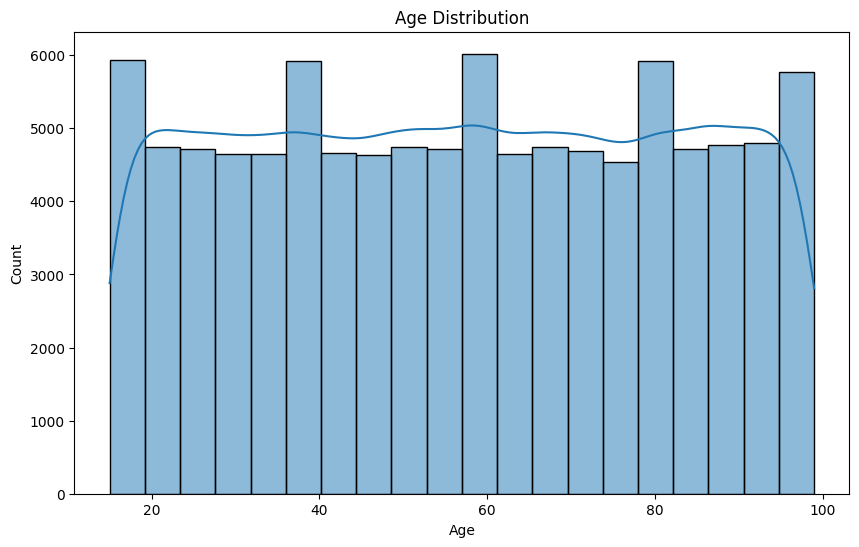

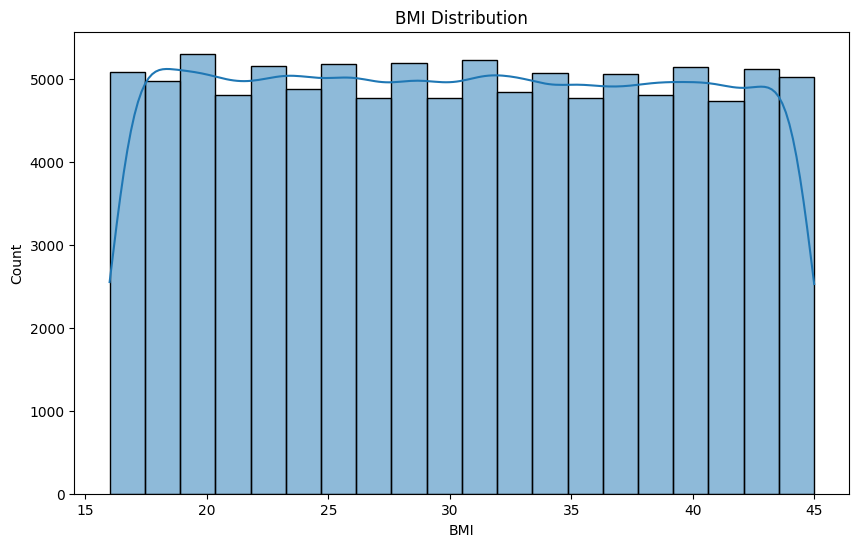

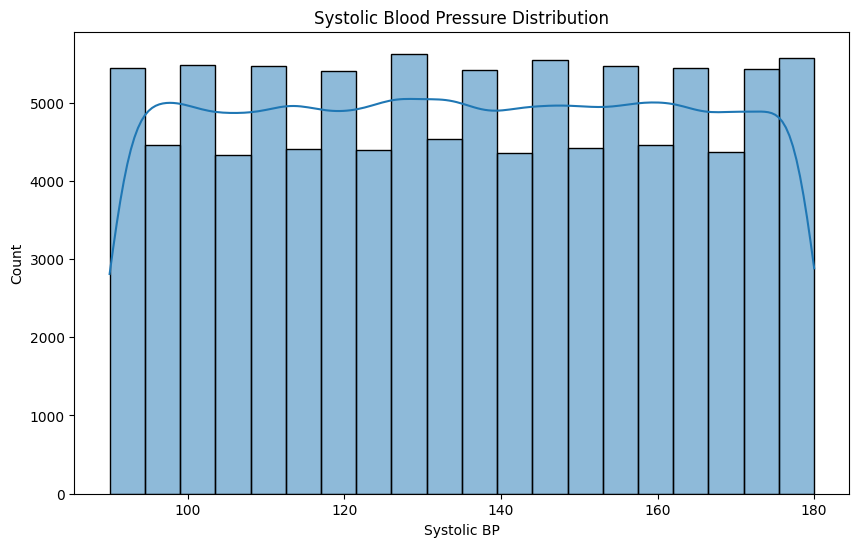

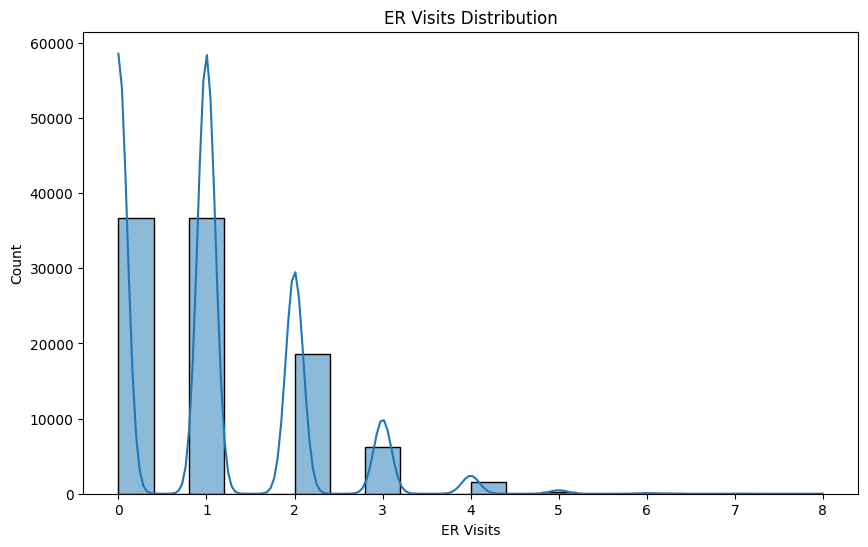

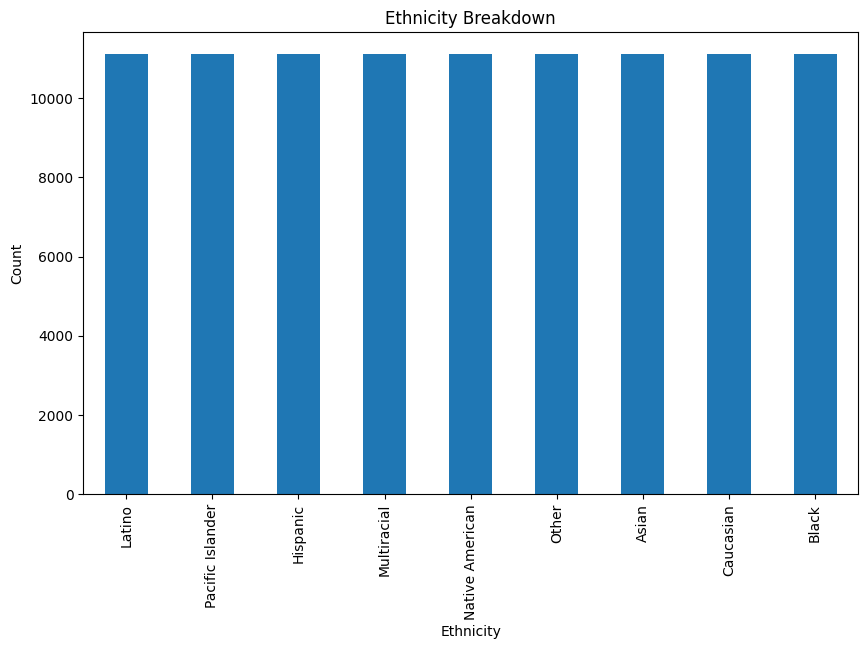

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the clean dataset
df = pd.read_csv("medical_clinical_data_clean.csv")

# --- Visualiazation --

# age distruibution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# BMI distruibution
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=20, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

# Systolic Blood pressure
plt.figure(figsize=(10, 6))
sns.histplot(df['systolic_bp'], bins=20, kde=True)
plt.title('Systolic Blood Pressure Distribution')
plt.xlabel('Systolic BP')
plt.ylabel('Count')
plt.show()

# ER Visits
plt.figure(figsize=(10, 6))
sns.histplot(df['num_er_visits_last_year'], bins=20, kde=True)
plt.title('ER Visits Distribution')
plt.xlabel('ER Visits')
plt.ylabel('Count')
plt.show()

# Ehtnicity Breakdown
plt.figure(figsize=(10, 6))
df['ethnicity'].value_counts().plot(kind='bar')
plt.title('Ethnicity Breakdown')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()



Model Training and Ecvaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Load the clean dataset
df = pd.read_csv("medical_clinical_data_clean.csv")

# Convert last_visit_date to datetime
df['last_visit_date'] = pd.to_datetime(df['last_visit_date'])

# Feature Engineering: Extract numerical features from last_visit_date
df['visit_year'] = df['last_visit_date'].dt.year
df['visit_month'] = df['last_visit_date'].dt.month
df['visit_day'] = df['last_visit_date'].dt.day

# Drop the original date column and the first_name column
df = df.drop(columns=['last_visit_date', 'first_name'])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['gender', 'ethnicity', 'insured', 'diagnosis_code', 'smoking_status'])

# For chronic_conditions and medications, we can create dummy variables for each unique condition/medication
# First, ensure they are treated as strings and handle potential NaNs
df['chronic_conditions'] = df['chronic_conditions'].astype(str).fillna('')
df['medications'] = df['medications'].astype(str).fillna('')

# Split the comma-separated strings into lists and get unique values
all_conditions = sorted(list(set(','.join(df['chronic_conditions']).split(','))))
all_medications = sorted(list(set(','.join(df['medications']).split(','))))

# Create new columns for each condition and medication
for condition in all_conditions:
    if condition: # Avoid creating a column for empty strings
        df[f'condition_{condition.strip()}'] = df['chronic_conditions'].apply(lambda x: 1 if condition.strip() in x else 0)

for medication in all_medications:
     if medication: # Avoid creating a column for empty strings
        df[f'medication_{medication.strip()}'] = df['medications'].apply(lambda x: 1 if medication.strip() in x else 0)


# Drop the original chronic_conditions and medications columns
df = df.drop(columns=['chronic_conditions', 'medications'])

# Perpare data
X = df.drop(columns=['num_er_visits_last_year'])
y = df['num_er_visits_last_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("🔍 RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("🔍 R^2 Score:", r2_score(y_test, y_pred))

# Prediction vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual ER Visits")
plt.ylabel("Predicted ER Visits")
plt.title("Actual vs Predicted ER Visits")
plt.show()

Feature Importance

In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

# Conclusion

This notebook demonstrates the use of synthetic healthcare data to build a predictive model for ER utilization.

Key Takeaways:
- Data was engineered to include chronic condition count, medication count, and visit timing
- Random Forest was able to moderately predict ER visit counts (R² indicates room for improvement)
- Feature importance shows clinical indicators like chronic conditions and BMI play a significant role

This framework can be extended to:
- Predict other outcomes (e.g., hospital admission, chronic disease risk)
- Build classification models for "high utilizers"
- Integrate time series data for repeat visit analysis

Next Steps:
- Try Poisson or XGBoost for better count modeling
- Add additional behavioral or geographic features